## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration parameter calculation with chessboard images

Number of calibration images loaded: 20
Number of sucessfully processed calibration images: 17
17


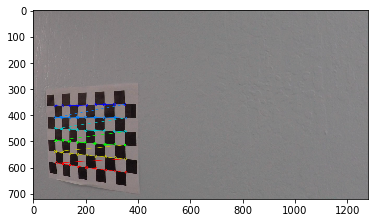

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
print('Number of calibration images loaded:', len(images))

# Step through the list and search for chessboard corners
for ID, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Draw & save found corners on calibration images
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_file = '../output_images/corners_found'+str(ID)+'.jpg'
        #cv2.imwrite(write_file, img)

# Draw and display the corners of the last calibration file
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img)

print('Number of sucessfully processed calibration images:', len(objpoints))
print(len(imgpoints))

#Compute camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
#Retrieve saved objpoints and imgpoints for distortion correction

#dist_pickle = pickle.load( open("../calib.p", "rb" ))
#objpoints = dist_pickle["objpoints"]
#imgpoints = dist_pickle["imgpoints"]




## 2. Camera distortion correction

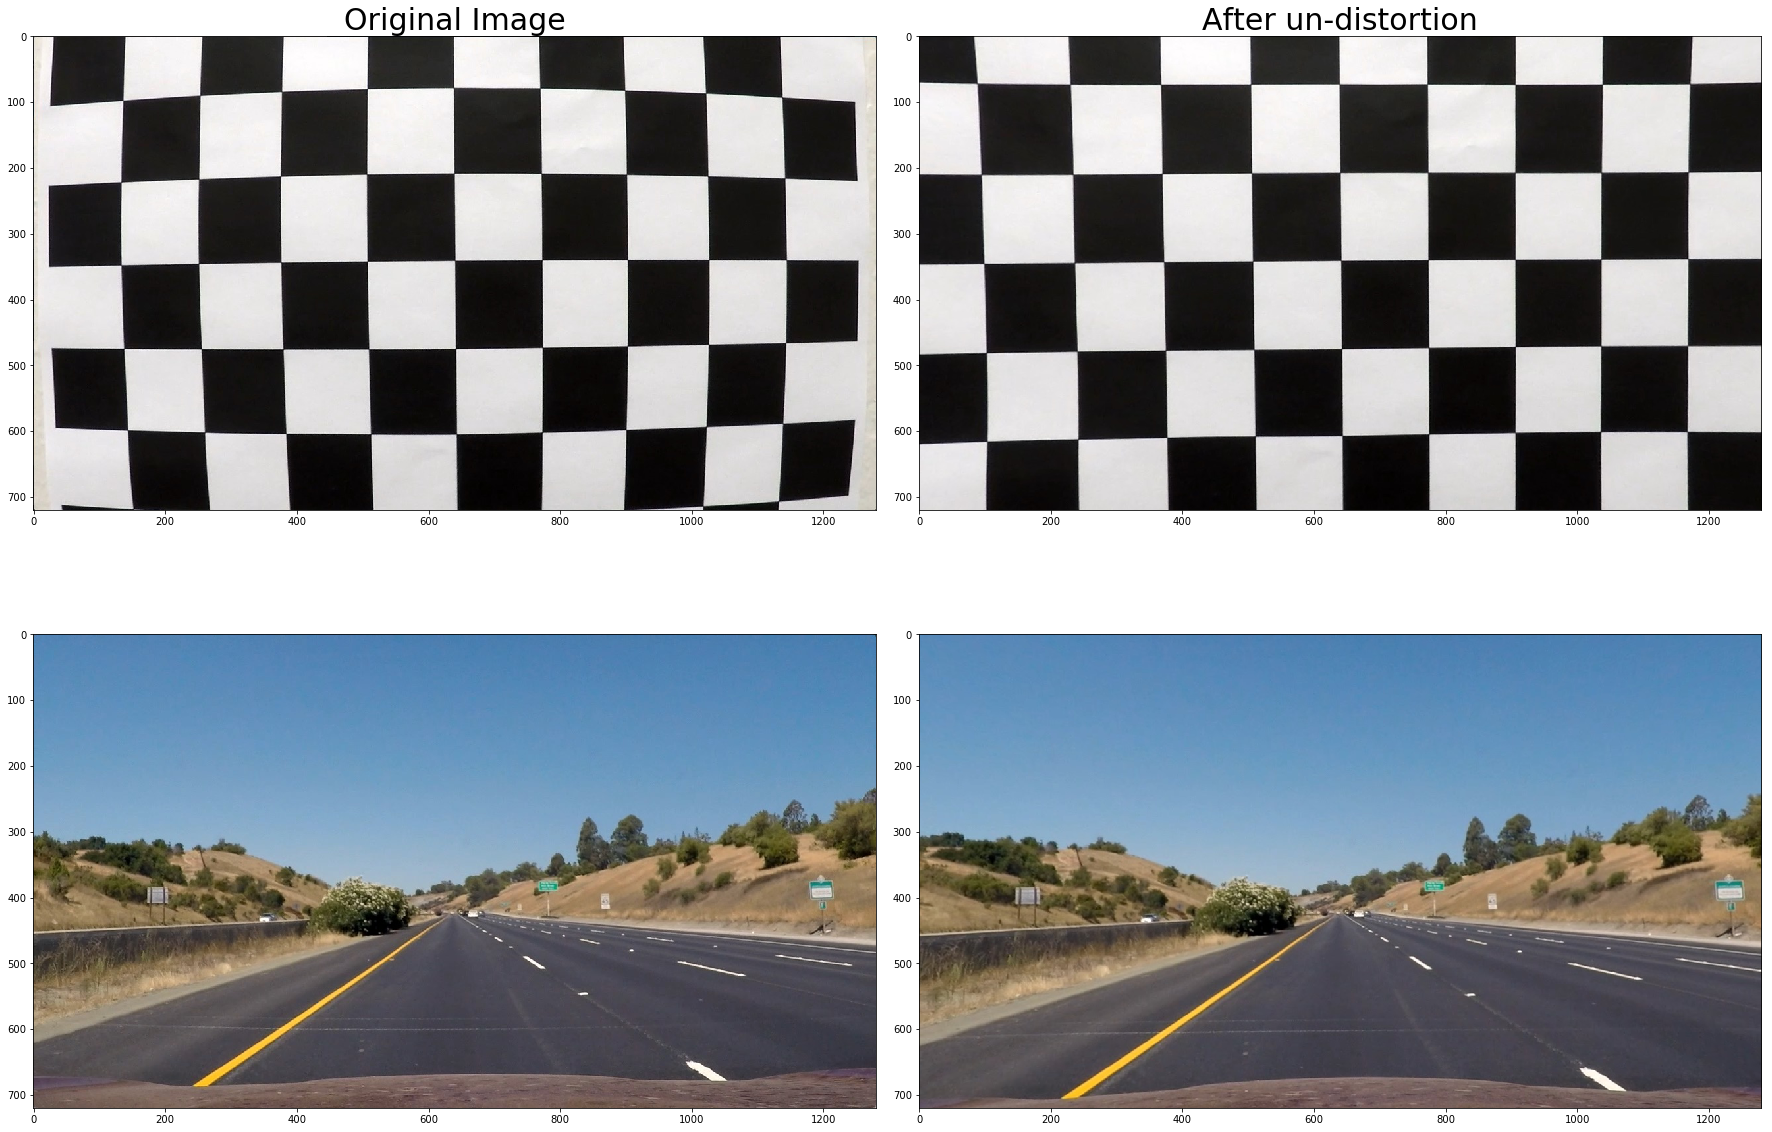

In [3]:
%matplotlib inline


cameracal1 = mpimg.imread('../camera_cal/calibration01.jpg')
testimg = mpimg.imread('../test_images/straight_lines1.jpg')
correctcam_cal1 = cv2.undistort(cameracal1, mtx, dist, None, mtx)
correctimg = cv2.undistort(testimg, mtx, dist, None, mtx)

f, ax = plt.subplots(2, 2, figsize=(24, 18))
ax = ax.ravel()
f.tight_layout()
ax[0].imshow(cameracal1)
ax[0].set_title('Original Image', fontsize=30)
ax[1].imshow(correctcam_cal1)
ax[1].set_title('After un-distortion', fontsize=30)
ax[2].imshow(testimg)
ax[3].imshow(correctimg)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#output_file = '../output_images/Undistorted/straight_lines1out.jpg'
#mpimg.imsave(output_file, correctimg)


## 3. Color & Gradient thresholding

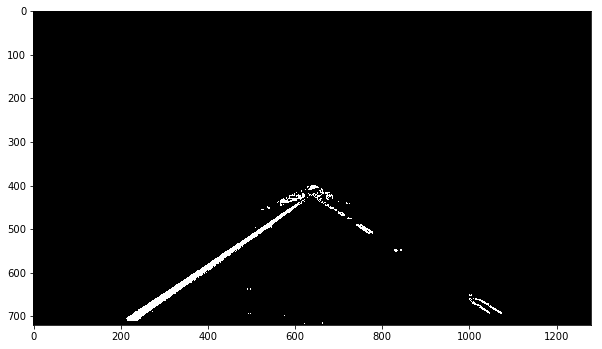

In [4]:

def img_threshold(img): #hls_select(img, thresh=(0, 255)):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    #R = img[:,:,0]                                     #Red channel is strong in Yellow & White lane markers
    #imghls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)      #HLS conversion
    #S = imghls[:,:,2]                                  #Sat channel is strong in Yellow & White lane markers
    #L = imghls[:,:,1]                                  #Lightness for Sobel calculations
    #S_thresh = (90, 255)
    #R_thresh = (100, 255)
    
    imglab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = imglab[:,:,2]                           # this is the B channel (blue/yellow)
    L = imglab[:,:,0]                           # Luminosity
    
    B_thresh = (140, 255)                       # this is the B channel threshold
    L_thresh = (180, 255)
    
    clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8))
    CL = clahe.apply(L)
    #CB = clahe.apply(B)
    #CLbinary_output = np.zeros_like(CL)
    #CLbinary_output[(CL>30) & (CL<=70)]=1
    
    Color_binary_output = np.zeros_like(L)
    Color_binary_output[(CL>L_thresh[0]) & (B>B_thresh[0])]=1    #Either high luminosity or high yellow will activate
    
    
    
    sobel_kernel = 7
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    Scaledabs_sobelx = np.uint8(255*np.absolute(sobelx)/np.max(np.absolute(sobelx)))
    thresh=(30, 150)
    SobelX_output = np.zeros_like(L)
    SobelX_output[(Scaledabs_sobelx >= thresh[0]) & (Scaledabs_sobelx <= thresh[1])] = 1
        
    combo_threshold = np.zeros_like(L)
    combo_threshold[(Color_binary_output==1) | (SobelX_output==1)] = 1  #Combine color & Sobel thresholds
    
    #Define Region of Interest to be lower triangular region of image
    ROI = np.zeros_like(L)
    vertices = np.array([[0, L.shape[0]], [L.shape[1]//2, 0.55*L.shape[0]], [L.shape[1], L.shape[0]]], dtype=np.int32)
    cv2.fillPoly(ROI, [vertices], 1)
        
    thresholdimg = cv2.bitwise_and(combo_threshold, ROI)
    
    return thresholdimg

#testimg = mpimg.imread('../test_images/straight_lines1.jpg')    
thresholded = img_threshold(testimg)

plt.figure(figsize=(10,10))
plt.imshow(thresholded, cmap='gray')

#output_file = '../output_images/Thresholded/straight_lines1out.jpg'
#mpimg.imsave(output_file, thresholded)

## 4. Perspective Transform & Bird's eye-view

(4, 2)
(4, 1, 2)


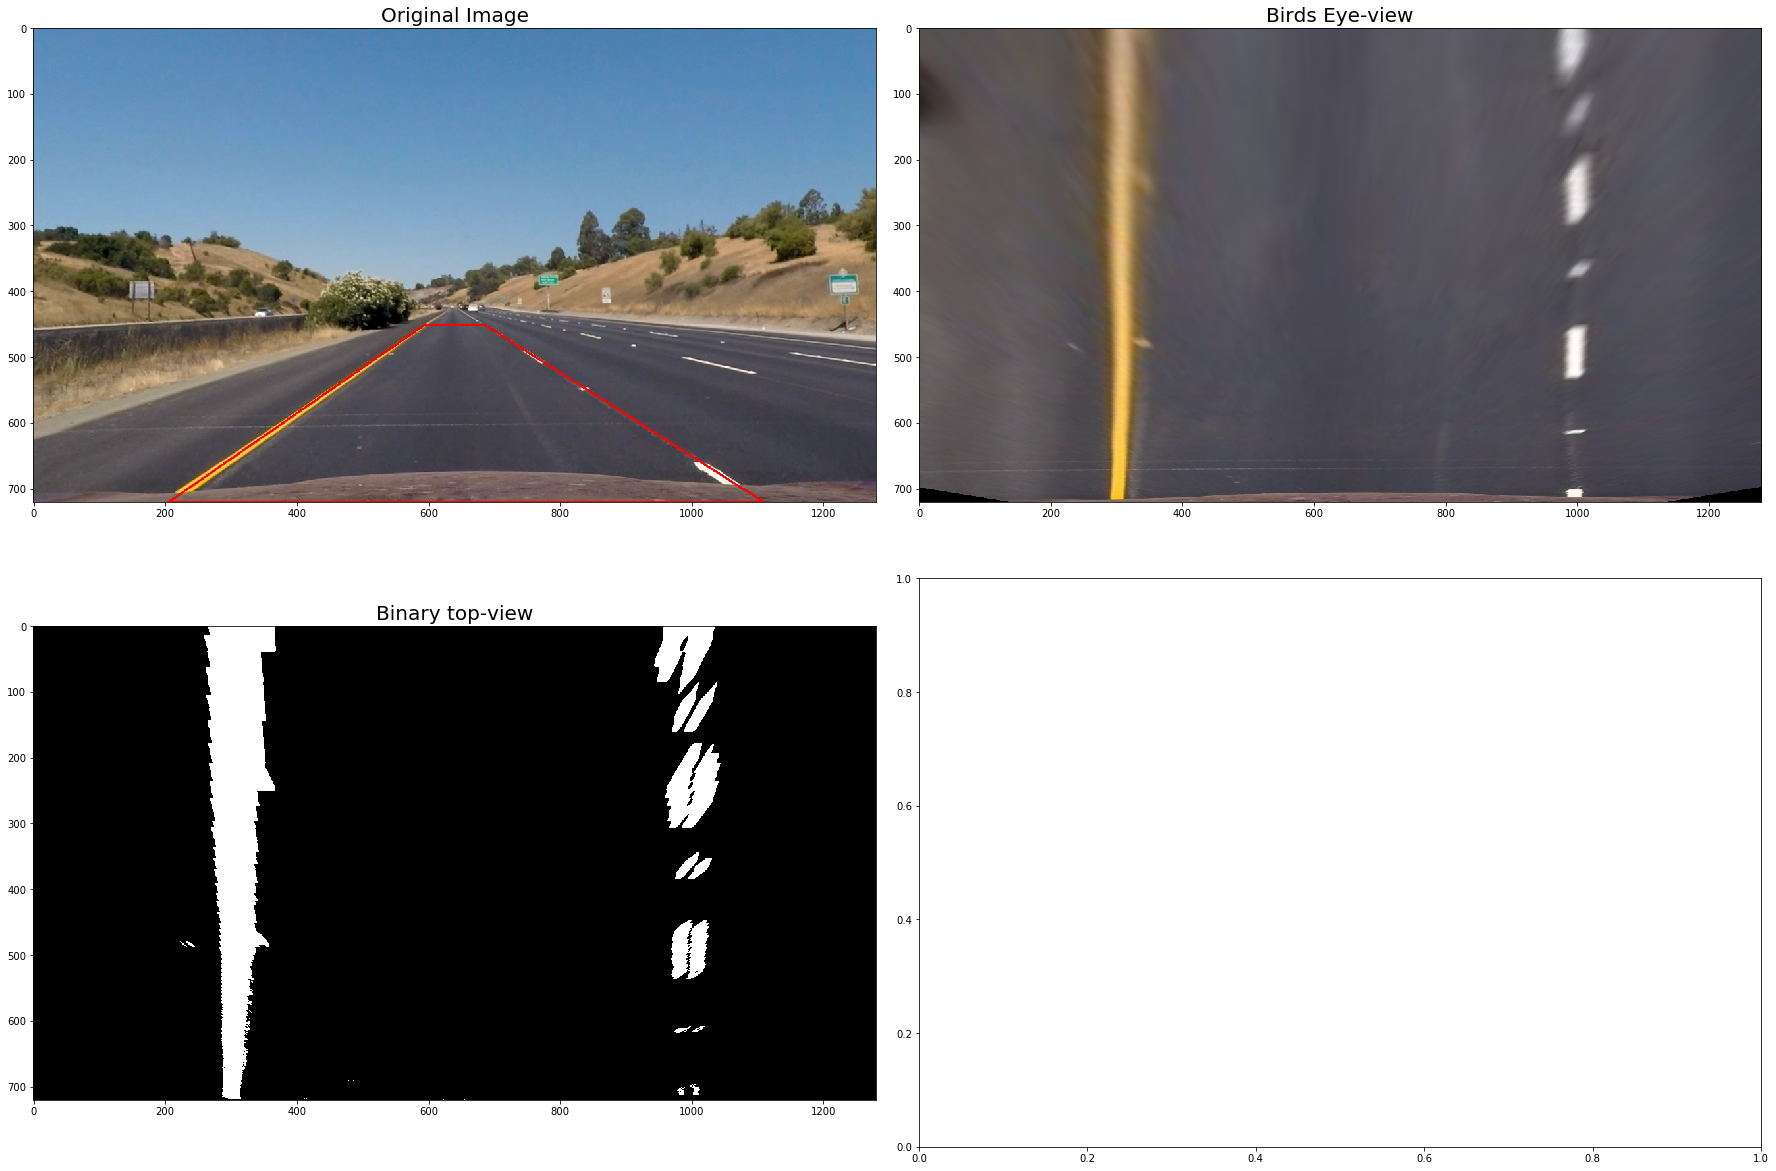

In [5]:
bottomL, bottomR, topR, topL  = [205, 720], [1110, 720], [685, 450], [595, 450]  #source coordinates
src = np.float32([bottomL, bottomR, topR, topL])
dest = np.float32([[300, 720], [1000, 720],[1000, 0], [300, 0]])

pts = np.array([bottomL, bottomR, topR, topL], np.int32)
print(pts.shape)
pts = pts.reshape((-1,1,2))
print(pts.shape)


img_size = (correctimg.shape[1], correctimg.shape[0])
M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest, src)

warped = cv2.warpPerspective(correctimg, M, img_size, flags = cv2.INTER_LINEAR)
binary_warped = cv2.warpPerspective(thresholded, M, img_size, flags = cv2.INTER_LINEAR)
copy = correctimg.copy()
cv2.polylines(copy,[pts] ,True,(255,0,0), thickness=2)

f, ax = plt.subplots(2, 2, figsize=(24, 18))
ax = ax.ravel()
f.tight_layout()
ax[0].imshow(copy)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(warped, cmap='gray')
ax[1].set_title('Birds Eye-view', fontsize=20)
ax[2].set_title('Binary top-view', fontsize=20)
ax[2].imshow(binary_warped, cmap='gray')
#ax[3].imshow(correctimg)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#output_file = '../output_images/Perspective_Transformed/test3out.jpg'
#mpimg.imsave(output_file, warped)
#out_file = '../output_images/Perspective_Transformed/test3_binaryout.jpg'
#mpimg.imsave(out_file, binary_warped)

## 5. Lane line finding using sliding-windows

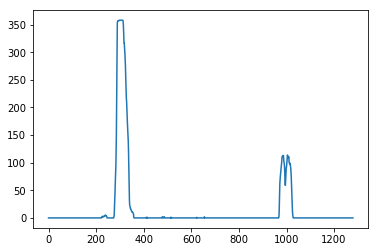

In [9]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

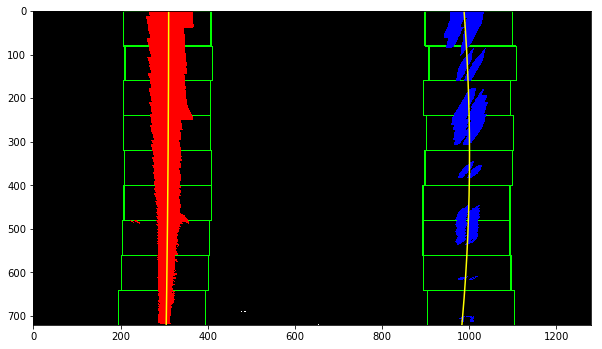

In [10]:

#Sliding Window lane-line search
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

#Visualization


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 6. Efficient lane-line finding

(720, 0)

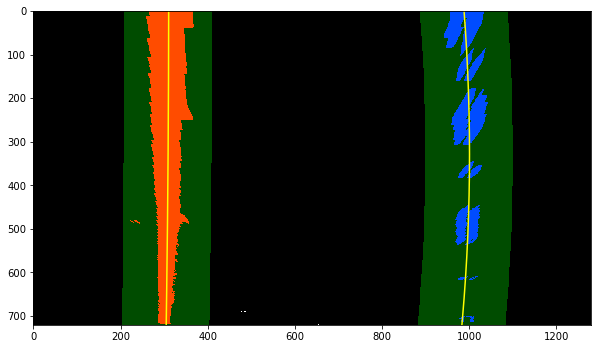

In [11]:
#Omit sliding windows after general line position is known
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                  & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                   & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 7. Lane line curvature and vehicle position estimation

In [19]:

y_eval = np.max(ploty)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

#Car position from the lane-center
lane_center = (right_fitx[-1] + left_fitx[-1])/2

center_offset_pix = abs(img_size[0]/2 - lane_center)
center_offset_m = xm_per_pix*center_offset_pix
print('Car is %.3f meters from center' % center_offset_m)


26674.6701124 m 1430.55010486 m
Car is 0.018 meters from center


## 8. Lane/ Path highlighting

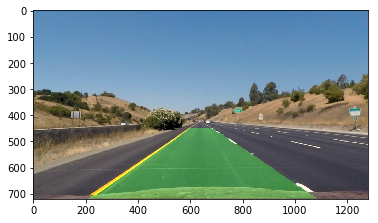

In [20]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(correctimg, 1, newwarp, 0.3, 0)
plt.imshow(result)

## 9. Function definitions for Image and Video processing pipeline

In [12]:
def sliding_windows(binary_warped):
    
    # Find the peak of the left and right halves of the histogram
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low)
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #Visualization
    # Generate x and y values for plotting
        
    return left_fit, right_fit

def faster_line_predictor(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    approx_spacing = right_fit[2] - left_fit[2]
    if approx_spacing < 100:
        left_fit, right_fit = sliding_windows(binary_warped)    #go back to sliding_windows calculation
    
    return left_fit, right_fit

def line_average_frame(avg_lines, new_line):
    num_stills = 10                             #this is the number of old frames to average over
    if new_line is None:
        if len(avg_lines) == 0:
            return avg_lines, None              #this will effectively force a sliding window search for lines
        else:
            return avg_lines, avg_lines[-1]
    else:
        if len(avg_lines) < num_stills:
            avg_lines.append(new_line)          #if less than target # stills in avg_lines, append new line
            return avg_lines, new_line
        else:                                   #if there are target # of stills in avg_lines
            avg_lines[0:num_stills-1] = avg_lines[1:num_stills]
            avg_lines[-1] = new_line
            new_line = np.average(avg_lines, axis=0)
            return avg_lines, new_line
            

## 10. Image processing pipeline

In [7]:
def process_image(img):
    
    global left_fit
    global right_fit
    global average_left_fitx
    global average_right_fitx
    
    img_size = (img.shape[1], img.shape[0])
    thresholded = img_threshold(img)
    
    #thresh = np.dstack((255*thresholded, 255*thresholded, thresholded))
    #process_output = cv2.addWeighted(img, 0.7, thresh, 1, 0)
    
    binary_warped = cv2.warpPerspective(thresholded, M, img_size, flags = cv2.INTER_LINEAR)
    
    if (left_fit is None) or (right_fit is None):                       #If no prior lane lines identified
        left_fit, right_fit = sliding_windows(binary_warped)            #do new sliding-windows line search
    else:
        left_fit, right_fit = faster_line_predictor(binary_warped, left_fit, right_fit) #else do localized search
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    average_left_fitx, left_fitx = line_average_frame(average_left_fitx, left_fitx)    #smoothing function
    average_right_fitx, right_fitx = line_average_frame(average_right_fitx, right_fitx)
    
    num_rows = binary_warped.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)
    
    # Lane-line curvature & position calculation
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_curve = 0.5*(left_curverad + right_curverad)
    print_curvature = 'Radius of lane-curvature: %.0f m' % average_curve

    #Car position from the lane-center
    lane_center = (right_fitx[-1] + left_fitx[-1])/2
    center_offset_pix = abs(img_size[0]/2 - lane_center)
    center_offset_m = xm_per_pix*center_offset_pix*100
    print_offset = 'Car is %.0f cm from center' % center_offset_m
    #diagL = 'Left %.0f  ' % left_fit[2]                           #Pipeline diagnostic display
    #diagR = 'Right %.0f' % right_fit[2]
    #diag = diagL + diagR
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result, print_curvature, (50, 75), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,0), thickness=2)
    cv2.putText(result, print_offset, (50, 110), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,0), thickness=2)
    
    #cv2.putText(result, diag, (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), thickness=2)
    #print('left', left_fit)
    #print('right', right_fit)
    
    return result



## 11. Test on images

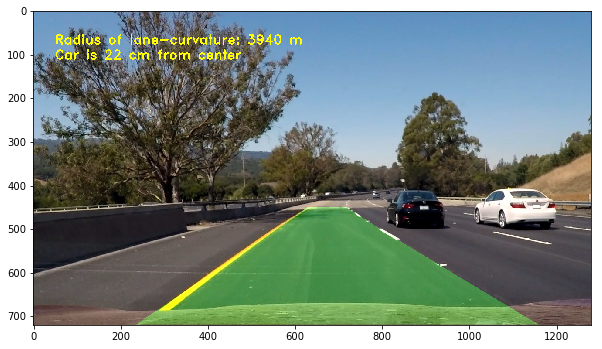

In [7]:
left_fit = None
right_fit = None
average_left_fitx = []
average_right_fitx = []
picture = mpimg.imread('../test_images/test6.jpg')                       
final_out = process_image(picture)

plt.figure(figsize=(10,10))
plt.imshow(final_out)

#output_file = '../output_images/Final_Output_Images/test6out.jpg'
#mpimg.imsave(output_file, final_out)

## 12. Video Pipeline

In [8]:
from moviepy.editor import VideoFileClip

left_fit = None
right_fit = None
average_left_fitx = []
average_right_fitx = []

output_video = '../hardchallengeout.mp4'
input_video = '../harder_challenge_video.mp4'
clip1 = VideoFileClip(input_video, audio=False)
video_out = clip1.fl_image(process_image)             #NOTE: this function expects color images!!
%time video_out.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ../challengeout824.mp4
[MoviePy] Writing video ../challengeout824.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:43<00:00, 11.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challengeout824.mp4 

Wall time: 44.3 s


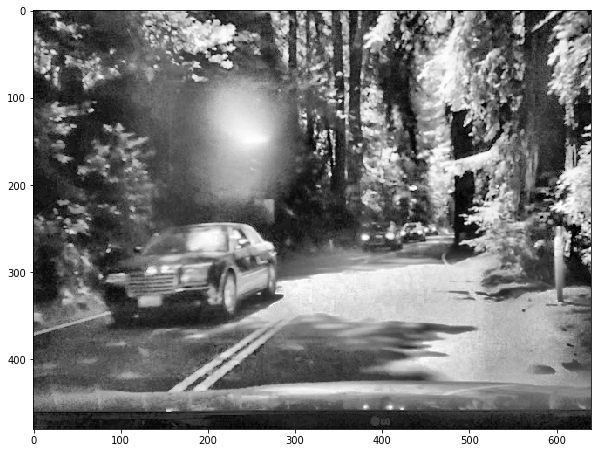

In [45]:

clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8))
cl = clahe.apply(L)
plt.figure(figsize=(10,10))
plt.imshow(cl, cmap='gray')
